In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sbs
import pickle
from copy import deepcopy
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', filename='info.log', level=logging.INFO)
sbs.set_style('darkgrid')

%matplotlib widget
# %matplotlib inline

In [2]:

class SineWave:
    
    def __init__(self, train_size=10, valid_size=5, synth_size=5, noise=0.1):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.resample(train_size, valid_size, synth_size, noise)
       
       
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def sample(self, size=10):
        x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return dict(x=torch.Tensor(x), y=torch.Tensor(y))
    
    def resample_synthetic(self, synth_size, noise=0.1):
        self.synth_set = self.sample(synth_size)
        self.synth_set['x']  = torch.normal(self.synth_set['x'], noise)
        
        
    def resample(self, train_size, valid_size, synth_size, noise):
        self.train_set = dict(x=torch.empty(0), y=torch.empty(0))
        self.valid_set = dict(x=torch.empty(0), y=torch.empty(0))
        self.synth_set = dict(x=torch.empty(0), y=torch.empty(0))
        self.z_set = dict(x=torch.empty(0), y=torch.empty(0))
        if train_size>0:
            self.train_set = self.sample(train_size)
        if valid_size>0:
            self.valid_set = self.sample(valid_size)
        if synth_size>0:
            self.synth_set = self.sample(synth_size)
#             self.synth_set['y'] = self.a * (2*torch.rand(self.synth_set['y'].shape)-1)
            self.synth_set['x']  = torch.normal(self.synth_set['x'], noise)
            
    
    def test_set(self, start=-5, stop=5, num=100):
        x = np.linspace(start, stop, num)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
   
    def save(self, path: str = 'wave.pickle'):
        with open(path, 'wb') as f:
            # Pickle the 'data'  using the highest protocol available.
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
            
    def plot(self, *args, **kwargs):
        plots = []
        legends = []
        
        if self.train_set['y'].nelement() > 0:
            train, = plt.plot(self.train_set['x'].numpy(), self.train_set['y'].numpy(), 'b^')
            plots.append(train)
            legends.append('Training Points 1')
        
        if self.synth_set['y'].nelement() > 0:
            synth, = plt.plot(self.synth_set['x'], self.synth_set['y'], 'ro')
            plots.append(synth)
            legends.append('Synthetic Points')
        
        if self.valid_set['y'].nelement() > 0:
            valid, = plt.plot(self.valid_set['x'], self.valid_set['y'], 'bx')
            plots.append(valid)
            legends.append('Training Points 2')
        
        x, y = self.test_set()
        test, = plt.plot(x.numpy(), y.numpy(), 'g', *args, **kwargs)
        plots.append(test)
        legends.append("True Function")
        plt.legend(plots, legends)



In [3]:


def load_wave(path: str = 'wave.pickle'):
    with open(path, 'rb') as f:
        self = pickle.load(f)
    return self
    

@torch.no_grad()
def armijo_step(model, gradients: torch.Tensor, steps: int, lr_meta: float, x: torch.Tensor, y: torch.Tensor):
    num_coords = len(gradients)
    lr = torch.tensor([lr_meta / (2 ** i) for i in range(steps)], dtype=torch.float32)
    lr_total = lr_meta * torch.ones(num_coords)

    for k in range(40):
        for i in range(num_coords):
            loss = 1e9 * torch.ones(steps)
            for j in range(steps):
                lr_total[i] = lr[j]
                logits = model(x, lr_total, gradients)
                loss[j] = F.mse_loss(logits, y.reshape_as(logits))
            lr_total[i] = lr[torch.argmin(loss)]
    return lr_total

class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 40)
        self.hidden2 = nn.Linear(40, 40)
        self.out = nn.Linear(40, 1)
        
    def save(self, path: str = 'model.pt'):
        torch.save(self.state_dict(), path)
        
    def forward(self, x, lr=None, gradients=None):
        if gradients is not None:
            layer1_weight = self.hidden1.weight - lr[0] * gradients[0]
            layer1_bias = self.hidden1.bias - lr[1] * gradients[1]
            layer2_weight = self.hidden2.weight - lr[2] * gradients[2]
            layer2_bias = self.hidden2.bias - lr[3] * gradients[3]
            out_weight = self.out.weight - lr[4] * gradients[4]
            out_bias = self.out.bias - lr[5] * gradients[5]
            x = F.relu(F.linear(x, layer1_weight, layer1_bias))
            x = F.relu(F.linear(x, layer2_weight, layer2_bias))
            x = F.linear(x, out_weight, out_bias)
            return x
            
        else:
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.out(x)
    
    def gradient_step_(self, lr, gradients):
        self.hidden1.weight.data = self.hidden1.weight.data - lr[0] * gradients[0]
        self.hidden1.bias.data = self.hidden1.bias.data - lr[1] * gradients[1]
        self.hidden2.weight.data = self.hidden2.weight.data - lr[2] * gradients[2]
        self.hidden2.bias.data = self.hidden2.bias.data - lr[3] * gradients[3]
        self.out.weight.data = self.out.weight.data - lr[4] * gradients[4]
        self.out.bias.data = self.out.bias.data - lr[5] * gradients[5]
        
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

In [4]:
from IPython import display


def fit(wave, net, epochs=10, use_valid=False):
    x_train, y_train = wave.train_set.values()
    x_valid, y_valid = torch.empty(0), torch.empty(0)
    if use_valid:
        x_valid, y_valid = wave.valid_set.values()
    x = torch.cat([x_train, x_valid])
    y = torch.cat([y_train, y_valid])
 
    optim = torch.optim.Adam(net.parameters(), lr=0.01)
    fig, ax = plt.subplots()
    for epoch in range(1, epochs+1):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.1)
        optim.zero_grad()
        loss = F.mse_loss(net(x[:, None]), y.unsqueeze(1))
        print(f"Loss at epoch #{epoch}: {loss.data}")
        loss.backward()
        optim.step()
        ax.cla()
        plot_sine_test(ax, wave, net, show_synth=False)

def fit_meta(wave, net, lr_meta=1e-2, lr_z=10, epochs=10, stage1=10, stage2=10):
    x_train, y_train = wave.train_set.values()
    x_valid, y_valid = wave.valid_set.values()
    x_all, y_all = torch.cat([x_train, x_valid]), torch.cat([y_train, y_valid])
    x_synth, y_synth = wave.synth_set.values()
    z = x_synth.clone().detach().requires_grad_(True)
    wave.z_set = dict(x=x_synth, y=y_synth)
    optimizer_z = torch.optim.Adam([z], lr=lr_z)
    optimizer_model = torch.optim.Adam(net.parameters(), lr=lr_meta)
    fig, ax = plt.subplots()
    for epoch in range(1, epochs+1):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.1)
        print(f"Epoch {epoch}")
        for i in range(stage1):
            y_hat_z = net(z[:, None])
            loss_z = F.mse_loss(y_hat_z, y_synth.reshape_as(y_hat_z)) 
            grad_z = grad(loss_z, net.parameters(), create_graph=True)

            # Create emulated network
            lr = armijo_step(net, grad_z, steps=20, lr_meta=lr_meta, x=x_all[:, None], y=y_all)
            
            logging.info(f"Epoch {epoch} armijo lr:{lr}")
            optimizer_z.zero_grad()
            logits = net(x_all[:, None], lr=lr, gradients=grad_z)
            loss = F.mse_loss(logits, y_all.reshape_as(logits))

            loss.backward()
            optimizer_z.step() # Updating z
            wave.z_set['x'] = z.clone().detach() # Saving new z
        
#         y_hat_x = net(x_all[:, None])
#         loss_x = F.mse_loss(y_hat_x, y_all.reshape_as(y_hat_x))
#         if (loss < loss_x):
#         logging.info(f"Epoch {epoch} Update Model {loss:.3} < {loss_x:.3}")
#             net.gradient_step_(lr, grad_z) # Save emulated network
        for i in range(stage2):
            optimizer_model.zero_grad()
            x = torch.cat([x_all, z])
            y = torch.cat([y_all, y_synth])
            logits = net(x[:, None])
            loss = F.mse_loss(logits, y.reshape_as(logits))
            loss.backward()
            optimizer_model.step()
#         else:
#             ...
        
        ax.cla()
        plot_sine_test(ax, wave, net)


    
        
@torch.no_grad()
def eval_net(wave, net):
    x, _ = wave.test_set()
    y = net(x[:, None])
    return x.squeeze().numpy(), y.squeeze().numpy()

def plot_sine_test(ax, wave, net, show_synth=True):
    
    
    xtrain, ytrain = wave.train_set.values()
    xvalid, yvalid = wave.valid_set.values()
    xsynth, ysynth = wave.synth_set.values()
    z, yz = wave.z_set.values()
    
    start = torch.min(torch.cat([xtrain, xvalid, xsynth, z]))-0.5
    stop = torch.max(torch.cat([xtrain, xvalid, xsynth, z]))+0.5
    xtest, ytest = wave.test_set(start, stop)
    
    with torch.no_grad():
        res = net(xtest[:, None])
    
    ax.plot(xtrain.numpy(), ytrain.numpy(), 'b^', label='Training Points 1')
    ax.plot(xtest.numpy(), ytest.numpy(), 'g', label='True Function')
    ax.plot(xvalid.numpy(), yvalid.numpy(), 'bx', label='Training Points 2')
    if hasattr(wave, 'z_set') and show_synth:
        
        ax.plot(z.numpy(), yz.numpy(), 'ro', label='Synthetic Points')
        
    ax.plot(xtest.numpy(), res, 'C1--', label="Model")    
    ax.legend()


### Sine Wave Dataset

In [16]:
# wave = SineWave(train_size=5,  valid_size=5, synth_size=10, noise=1.5)
wave.save('wave.pickle')

In [35]:
wave.resample_synthetic(20, noise=0.5)
wave.save('wave.pickle')

In [5]:
wave = load_wave('wave.pickle')

plt.close('all')
wave.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Fitting the baseline net on train and validation 

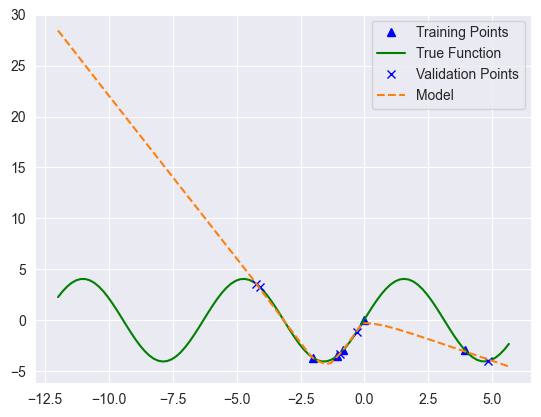

Loss at epoch #100: 0.018381960690021515


In [13]:
net = SineModel()
wave = load_wave('wave.pickle')
fit(wave, net, epochs=100, use_valid=True)
net.save('baseline.pt')

In [50]:
net = SineModel()
net.load_state_dict(torch.load('baseline.pt'))
plt.close('all')
fig, ax = plt.subplots()
plot_sine_test(ax, wave, net, show_synth=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Fitting the model on train set only

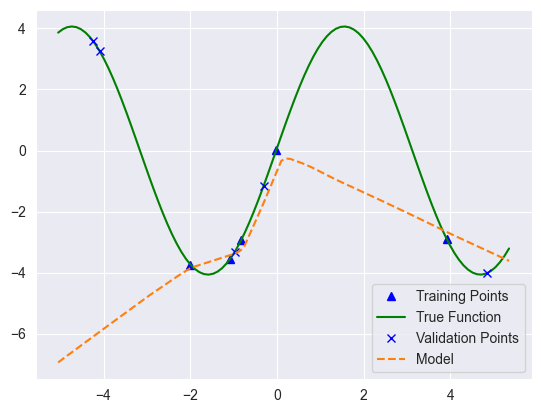

Loss at epoch #100: 0.02441978082060814


In [21]:
net = SineModel()
wave = load_wave('wave.pickle')
fit(wave, net, epochs=100, use_valid=False)
net.save('model.pt')

In [15]:
net = SineModel()
net.load_state_dict(torch.load('model.pt'))
plt.close('all')
fig, ax = plt.subplots()
plot_sine_test(ax, wave, net, show_synth=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Fitting the model with meta training on synthtetic dataset

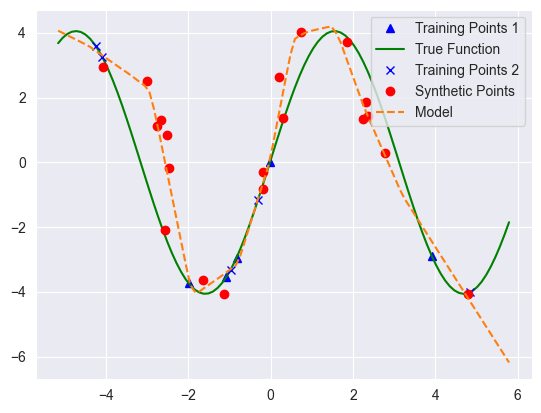

Epoch 50


In [5]:
wave = load_wave('wave.pickle')
net = SineModel()
net.load_state_dict(torch.load('model.pt'))
fit_meta(wave, net, lr_z=0.1, lr_meta=1e-2, epochs=50, stage1=10, stage2=10)
net.save('model_meta.pt')
wave.save('wave_meta.pickle')

In [69]:
wave = load_wave('wave_meta_50.pickle')
net = SineModel()
plt.close('all')
fig, ax = plt.subplots()

# Data
xtrain, ytrain = wave.train_set.values()
xvalid, yvalid = wave.valid_set.values()
xtest, ytest = wave.test_set(-5, 6)
z, yz = wave.z_set.values()

# Plot Data 
ax.plot(xtrain.numpy(), ytrain.numpy(), 'b^', label='Training Points 1')
ax.plot(xtest.numpy(), ytest.numpy(), 'g', label='True Function')
ax.plot(xvalid.numpy(), yvalid.numpy(), 'bx', label='Training Points 2')
ax.plot(z.numpy(), yz.numpy(), 'ro', label='Synthetic Points')

# Plot meta model
net.load_state_dict(torch.load('model_meta_50.pt'))
with torch.no_grad():
    res = net(xtest[:, None])
ax.plot(xtest.numpy(), res, 'C1--', label="model")   

#Plot baseline model
net.load_state_dict(torch.load('baseline.pt'))
with torch.no_grad():
    res = net(xtest[:, None])
ax.plot(xtest.numpy(), res, 'C4--', label="baseline") 

ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …